## Objective - Create a ML system that detects and classifies hand-written digits

#### Import modules and prepare dataset

In [1]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
%matplotlib inline

# Import other modules.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pygame
from tkinter import *
from tkinter import messagebox
from time import time
from plyer import notification
from scipy.ndimage.interpolation import shift
from skimage.transform import rescale
from random import choice
import cv2
from IPython.display import clear_output

# NOTE: To import 'plyer' module, you must use 'pip install plyer'

# Getting workspace/project to create a path that leads to the dataset.
print(os.getcwd())

# Import dataset.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# NOTE: You can download these files @: https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_train.csv

# X is the hand written digits, y is the actual digits (answers).
X_train, y_train = (train.loc[:, '1x1':'28x28'].to_numpy(), train['label'].to_numpy())
X_test, y_test = (test.loc[:, '1x1':'28x28'].to_numpy(), test['label'].to_numpy())

# X represents the hand written digits which are 28 x 28 in size.
print(f'X_train.shape: {X_train.shape}')    # -> (60,000, 784)

# Y is the actual digits they represent.
print(f'y_train.shape: {y_train.shape}')    # -> (60,000,)

print(f'X_test.shape: {X_test.shape}')    # -> (10,000, 784)
print(f'y_test.shape: {y_test.shape}')    # -> (10,000,)

pygame 2.0.0 (SDL 2.0.12, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
c:\Users\rohan\Documents\Software Development\AI\Projects\AI Predicts Hand-Written Digits
X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


#### Visualize the data using TSNE dimensionality technique

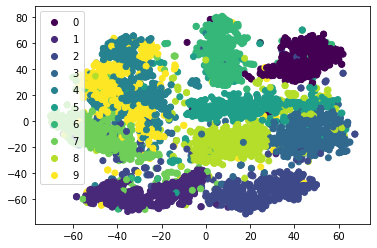

In [3]:
tsne = TSNE()

X_test_trans = tsne.fit_transform(X_test[:5000])

scatter = plt.scatter(X_test_trans[:, 0], X_test_trans[:, 1], c=y_test[:5000])
plt.legend(*scatter.legend_elements())
plt.show()

# Data is formed in clusters and looks to be linearly seperable.


#### Data analysis

Text(0.5, 1.0, 'After reform_data()')

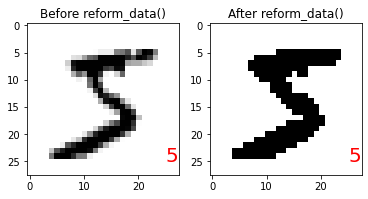

In [2]:
data = np.concatenate((X_train, X_test))
target = np.concatenate((y_train, y_test))

# Check % of data that's 0.
percent_of_zeros = np.sum(data == 0)/data.size    # -> 80%
percent_of_non_zeros = np.sum(data != 0)/data.size    # -> 20%

# Check for null values.
check_null = np.isnan(np.sum(data))    # -> False

# Change the data so that every value is the same (0 or ___).
all_values = []

for sub_arr in data:
    for i in sub_arr:
        if i != 0:
            all_values.append(i)

average_val = sum(all_values)/len(all_values)    # -> 174.4

# Create scaler.
scaler = MinMaxScaler()

# Reform the data according to value.
def reform_data(arr, scale=None):
    new_arr = []
    for sub_arr in arr:
        new_arr.append([])
        index = new_arr.index([])    # Finds index of new row/sample.
        for i in sub_arr:
            if i != 0:
                new_arr[index].append(average_val)
            else:
                new_arr[index].append(0)

    return np.array(new_arr) if scale is None else scale(np.array(new_arr))

# Keep one sample to compare.
sample = X_train[0]

# Reform the data.
X_train = reform_data(X_train, scaler.fit_transform)
X_test = reform_data(X_test, scaler.transform)

# Change data to image data.
X_train = X_train.reshape((60000, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((10000, 28, 28, 1)).astype('float32')

# Change to categorical data.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Check how X_train sample is now different.
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample.reshape(28, 28), cmap='binary')
ax1.text(25, 25, np.where(y_train[0] == 1)[0][0], fontsize=20, color='red')
ax1.set_title('Before reform_data()')

ax2.imshow(X_train[0], cmap='binary')
ax2.text(25, 25, np.where(y_train[0] == 1)[0][0], fontsize=20, color='red')
ax2.set_title('After reform_data()')


#### Apply linear model to the data

In [3]:
perceptron = Perceptron(max_iter=99999999)    # Perceptron only works when data is linear.

# NOTE: Perceptron is a neural network with only one hidden-layer.

# Reform the data for Perceptron().
reform_sklearn = lambda target : np.array([np.argmax(sample) for sample in target])

perceptron_X_trian, perceptron_X_test = (X_train.reshape(60000, 784), X_test.reshape(10000, 784))
perceptron_y_train, perceptron_y_test = (reform_sklearn(y_train), reform_sklearn(y_test))

start_time = time()

perceptron.fit(perceptron_X_trian, perceptron_y_train)

print(f'Perceptron train score: {perceptron.score(perceptron_X_trian, perceptron_y_train)}')
print(f'Perceptron test score: {perceptron.score(perceptron_X_test, perceptron_y_test)}')
print(f'Number of iterations used: {perceptron.n_iter_}')
print(f'Elapsed: {(time() - start_time)/60:.2f} min.')

Perceptron train score: 0.8659333333333333
Perceptron test score: 0.8578
Number of iterations used: 19
Elapsed: 0.24 min.


#### Apply model to the data

In [4]:
def model():
    
    # Create model.
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
	
    # Compile model.
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# NOTE: Sequential() models allow you to make models layer-by-layer and is much simpler compared to Input() models.
#       Conv2D() is an input layer for converting an image in to a matrix.
#       MaxPooling2D() is another input layer.
#       Flatten() converts multi-dimensional data into a single vector to be processed. Ex: 28 x 28 -> 784
#       Dense() is an output layer.
#       SGD() is stochastic gradient descent where it is used to update the weights.

# Create timer.
start_time = time()

CNN = model()
CNN.fit(X_train, y_train, epochs=5, batch_size=128)

# Clear the output.
clear_output()

# NOTE: batch_size param means that the model will be tested on 64 samples at a time.
#       This save a ton of RAM.

print(train_score := 'CNN Train Score: {:.2f}'.format(CNN.evaluate(X_train, y_train, verbose=False)[1]*100))
print(test_score := 'CNN Test Score: {:.2f}'.format(CNN.evaluate(X_test, y_test, verbose=False)[1]*100))
print(elapsed := f'Elapsed: {(time() - start_time)/60:.2f} min.')

# Notify when done.
notification.notify(
    title='Neural Network Training Results',
    message=f'{train_score}\n{test_score}\n{elapsed}',
    app_icon='python_icon.ico'
)

CNN Train Score: 98.88
CNN Test Score: 98.02
Elapsed: 1.90 min.


#### Test the model through visualizations

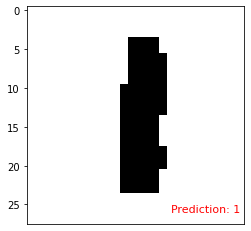

In [5]:
# Create a list of predictions.
sample = np.array(choice(X_test).reshape(1, 28, 28, 1))
prediction = np.argmax(CNN.predict(sample))

sample_img = sample.reshape(28, 28)

plt.imshow(sample_img, cmap='binary')
plt.text(18, 26, f'Prediction: {prediction}', fontsize=11, color='red')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

#### Create camera interface

In [17]:
def _get_available_gpus():
    devices = tf.config.list_logical_devices()
    device_names = [device.name for device in devices]
    return [device for device in device_names if 'device:gpu' in device.lower()]

def get_img_contour_thresh(img):
    x, y, w, h = 0, 0, 300, 300
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (35, 35), 0)
    ret, thresh1 = cv2.threshold(blur, 70, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh1 = thresh1[y:y + h, x:x + w]
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    return img, contours, thresh1

def main():

    cap = cv2.VideoCapture(0)
    while (cap.isOpened()):
        ret, img = cap.read()
        img, contours, thresh = get_img_contour_thresh(img)
        ans1 = ''

        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            if cv2.contourArea(contour) > 2500:
                x, y, w, h = cv2.boundingRect(contour)
                newImage = thresh[y:y + h, x:x + w]
                newImage = cv2.resize(newImage, (28, 28))
                newImage = np.array(newImage)
                newImage = newImage.flatten()
                newImage = scaler.transform(newImage.reshape(1, 784))
                ans1 = CNN.predict(newImage.reshape(1, 28, 28, 1))
                ans1=ans1.tolist()
                ans1 = ans1[0].index(max(ans1[0]))

        x, y, w, h = 0, 0, 300, 300
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.putText(img, " Prediction : " + str(ans1), (10, 330),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        #change the window size to fit screen properly
        #img = cv2.resize(img, (1000, 600))
        cv2.imshow("Frame", img)
        cv2.imshow("Contours", thresh)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

main()